# Import necessary libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import importlib

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Portfolio Allocation\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [7]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search_2d import naive_grid_search_2d
from lib.ngs.utils_ngs_2d import get_sup_error_2d
from lib.ngs.loss_fn import allocation_cost

# Load data

In [8]:
# file path for Colab. May need to change this
# X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
# y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')
decomp_cov_df = pd.read_csv('decomp_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [9]:
decomp_cov = np.array(decomp_cov_df)
mean = np.array(mean_df).squeeze()

In [10]:
decomp_cov = torch.tensor(decomp_cov, dtype=torch.float32)
mean = torch.tensor(mean, dtype=torch.float32)

In [11]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )
# test data
test_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )

In [12]:
lam_max_2d = [1, 1]
lam_min_2d = [.2, 0]
input_dim = decomp_cov.shape[1] - 1

In [13]:
import time

In [14]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_2d.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,11.873921,11.881741,11.889559,11.897371,11.905178,11.912983,11.920783,11.928581,11.936375,11.944160,...,12.578455,12.587327,12.596248,12.605223,12.614251,12.623341,12.632490,12.641709,12.651000,12.660363
1,11.783159,11.790983,11.798801,11.806616,11.814426,11.822233,11.830036,11.837837,11.845632,11.853424,...,12.472400,12.479905,12.487406,12.494905,12.502397,12.509891,12.517379,12.524865,12.532348,12.539825
2,11.692369,11.700192,11.708014,11.715832,11.723646,11.731454,11.739262,11.747060,11.754859,11.762651,...,12.381763,12.389266,12.396768,12.404266,12.411763,12.419257,12.426744,12.434232,12.441715,12.449197
3,11.601552,11.609380,11.617203,11.625022,11.632838,11.640651,11.648460,11.656260,11.664064,11.671860,...,12.291098,12.298603,12.306105,12.313607,12.321102,12.328597,12.336088,12.343575,12.351059,12.358540
4,11.510705,11.518534,11.526361,11.534184,11.542002,11.549817,11.557629,11.565434,11.573238,11.581036,...,12.200409,12.207916,12.215418,12.222919,12.230417,12.237914,12.245402,12.252892,12.260375,12.267859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.969864,2.978415,2.986955,2.995483,3.003999,3.012504,3.020997,3.029477,3.037946,3.046404,...,3.701677,3.709504,3.717325,3.725142,3.732953,3.740760,3.748561,3.756358,3.764150,3.771936
96,2.870990,2.879577,2.888153,2.896716,2.905266,2.913805,2.922331,2.930845,2.939347,2.947837,...,3.604494,3.612329,3.620161,3.627986,3.635807,3.643622,3.651433,3.659238,3.667039,3.674835
97,2.771868,2.780495,2.789109,2.797710,2.806299,2.814875,2.823438,2.831988,2.840526,2.849051,...,3.507194,3.515039,3.522879,3.530715,3.538545,3.546370,3.554189,3.562004,3.569814,3.577618
98,2.672482,2.681151,2.689807,2.698451,2.707080,2.715697,2.724300,2.732890,2.741467,2.750031,...,3.409775,3.417630,3.425480,3.433325,3.441164,3.448998,3.456827,3.464651,3.472470,3.480284


In [15]:
true_losses = truth.to_numpy()

# Loss function

In [16]:
loss_fn = allocation_cost

Use the previously tuned lr = .5**7.

In [49]:
lr = .5**8

## Assume access to a true loss oracle

In [204]:
max_epochs = 500

In [ ]:
num_grid_list = np.arange(4, 24)
num_grid_list

array([4, 5, 6, 7, 8, 9])

In [ ]:
delta_list = 1/(num_grid_list**2)
delta_list

array([0.0625    , 0.04      , 0.02777778, 0.02040816, 0.015625  ,
       0.01234568])

In [ ]:
total_pass_list = []
sup_error_list = []
for num_grid in num_grid_list:
    # number of grids according to 1/sqrt(delta)
    delta = 1/(num_grid**2)
    num_grid_2d = [num_grid, num_grid]

    start_time = time.time()
    total_pass, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                                num_grid_2d=num_grid_2d, epochs=max_epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader, oracle=True,
                                true_loss_list=true_losses, stopping_criterion=delta, check_frequency=5, device=device)

    end_time = time.time()
    execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    sup_error = get_sup_error_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                  weights, np.array(hyper_params), test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total passes #: {total_pass}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)

In [ ]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_oracle.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_oracle.csv')

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_pass_list, np.log(sup_error_list), '--o')
plt.xlabel('# pass')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Assume no access to true loss

In [34]:
max_epochs = 500

In [23]:
num_grid_list = np.arange(4, 24)
num_grid_list

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

In [24]:
delta_list = 1/(num_grid_list**2)
delta_list

array([0.0625    , 0.04      , 0.02777778, 0.02040816, 0.015625  ,
       0.01234568, 0.01      , 0.00826446, 0.00694444, 0.00591716,
       0.00510204, 0.00444444, 0.00390625, 0.00346021, 0.00308642,
       0.00277008, 0.0025    , 0.00226757, 0.00206612, 0.00189036])

$\max_{\lambda \in \text{Grid}} h(\theta(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)$

In [ ]:
total_pass_list = []
sup_error_list = []
grid_error_list = []
for num_grid in num_grid_list:
    # number of grids according to 1/sqrt(delta)
    delta = 1/(num_grid**2)
    epochs = round(28 * np.log(1/delta))
    num_grid_2d = [num_grid, num_grid]

    # start_time = time.time()
    total_pass, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                                num_grid_2d=num_grid_2d, epochs=epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader,
                                oracle=False, true_loss_list=true_losses,
                                check_frequency=1, device=device)

    # end_time = time.time()
    # execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    # solution path error
    sup_error = get_sup_error_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                  weights, np.array(hyper_params), test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)
    grid_error_list.append(grid_pass_error)
    # print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")
    print(f"grid #: {num_grid} by {num_grid}\t total iteration #: {total_pass}\t sup error: {sup_error}\t grid pass error: {grid_pass_error}")

total_pass_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)
grid_error_list = np.array(grid_error_list)

grid #: 4 by 4	 total iteration #: 1248	 sup error: 0.08282136917114258	 grid pass error: 0.0239107608795166
grid #: 5 by 5	 total iteration #: 2250	 sup error: 0.05277109146118164	 grid pass error: 0.017102956771850586
grid #: 6 by 6	 total iteration #: 3600	 sup error: 0.035399436950683594	 grid pass error: 0.013053178787231445
grid #: 7 by 7	 total iteration #: 5341	 sup error: 0.02749395370483354	 grid pass error: 0.010290145874023438
grid #: 8 by 8	 total iteration #: 7424	 sup error: 0.019651889801025835	 grid pass error: 0.008577585220336914
grid #: 9 by 9	 total iteration #: 9963	 sup error: 0.015247106552124023	 grid pass error: 0.007166147232055664
grid #: 10 by 10	 total iteration #: 12900	 sup error: 0.013539314270019531	 grid pass error: 0.0061533451080322266
grid #: 11 by 11	 total iteration #: 16214	 sup error: 0.010829925537109375	 grid pass error: 0.005425930023193359
grid #: 12 by 12	 total iteration #: 20016	 sup error: 0.009692668914794922	 grid pass error: 0.004789

In [31]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_2d.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_2d.csv')

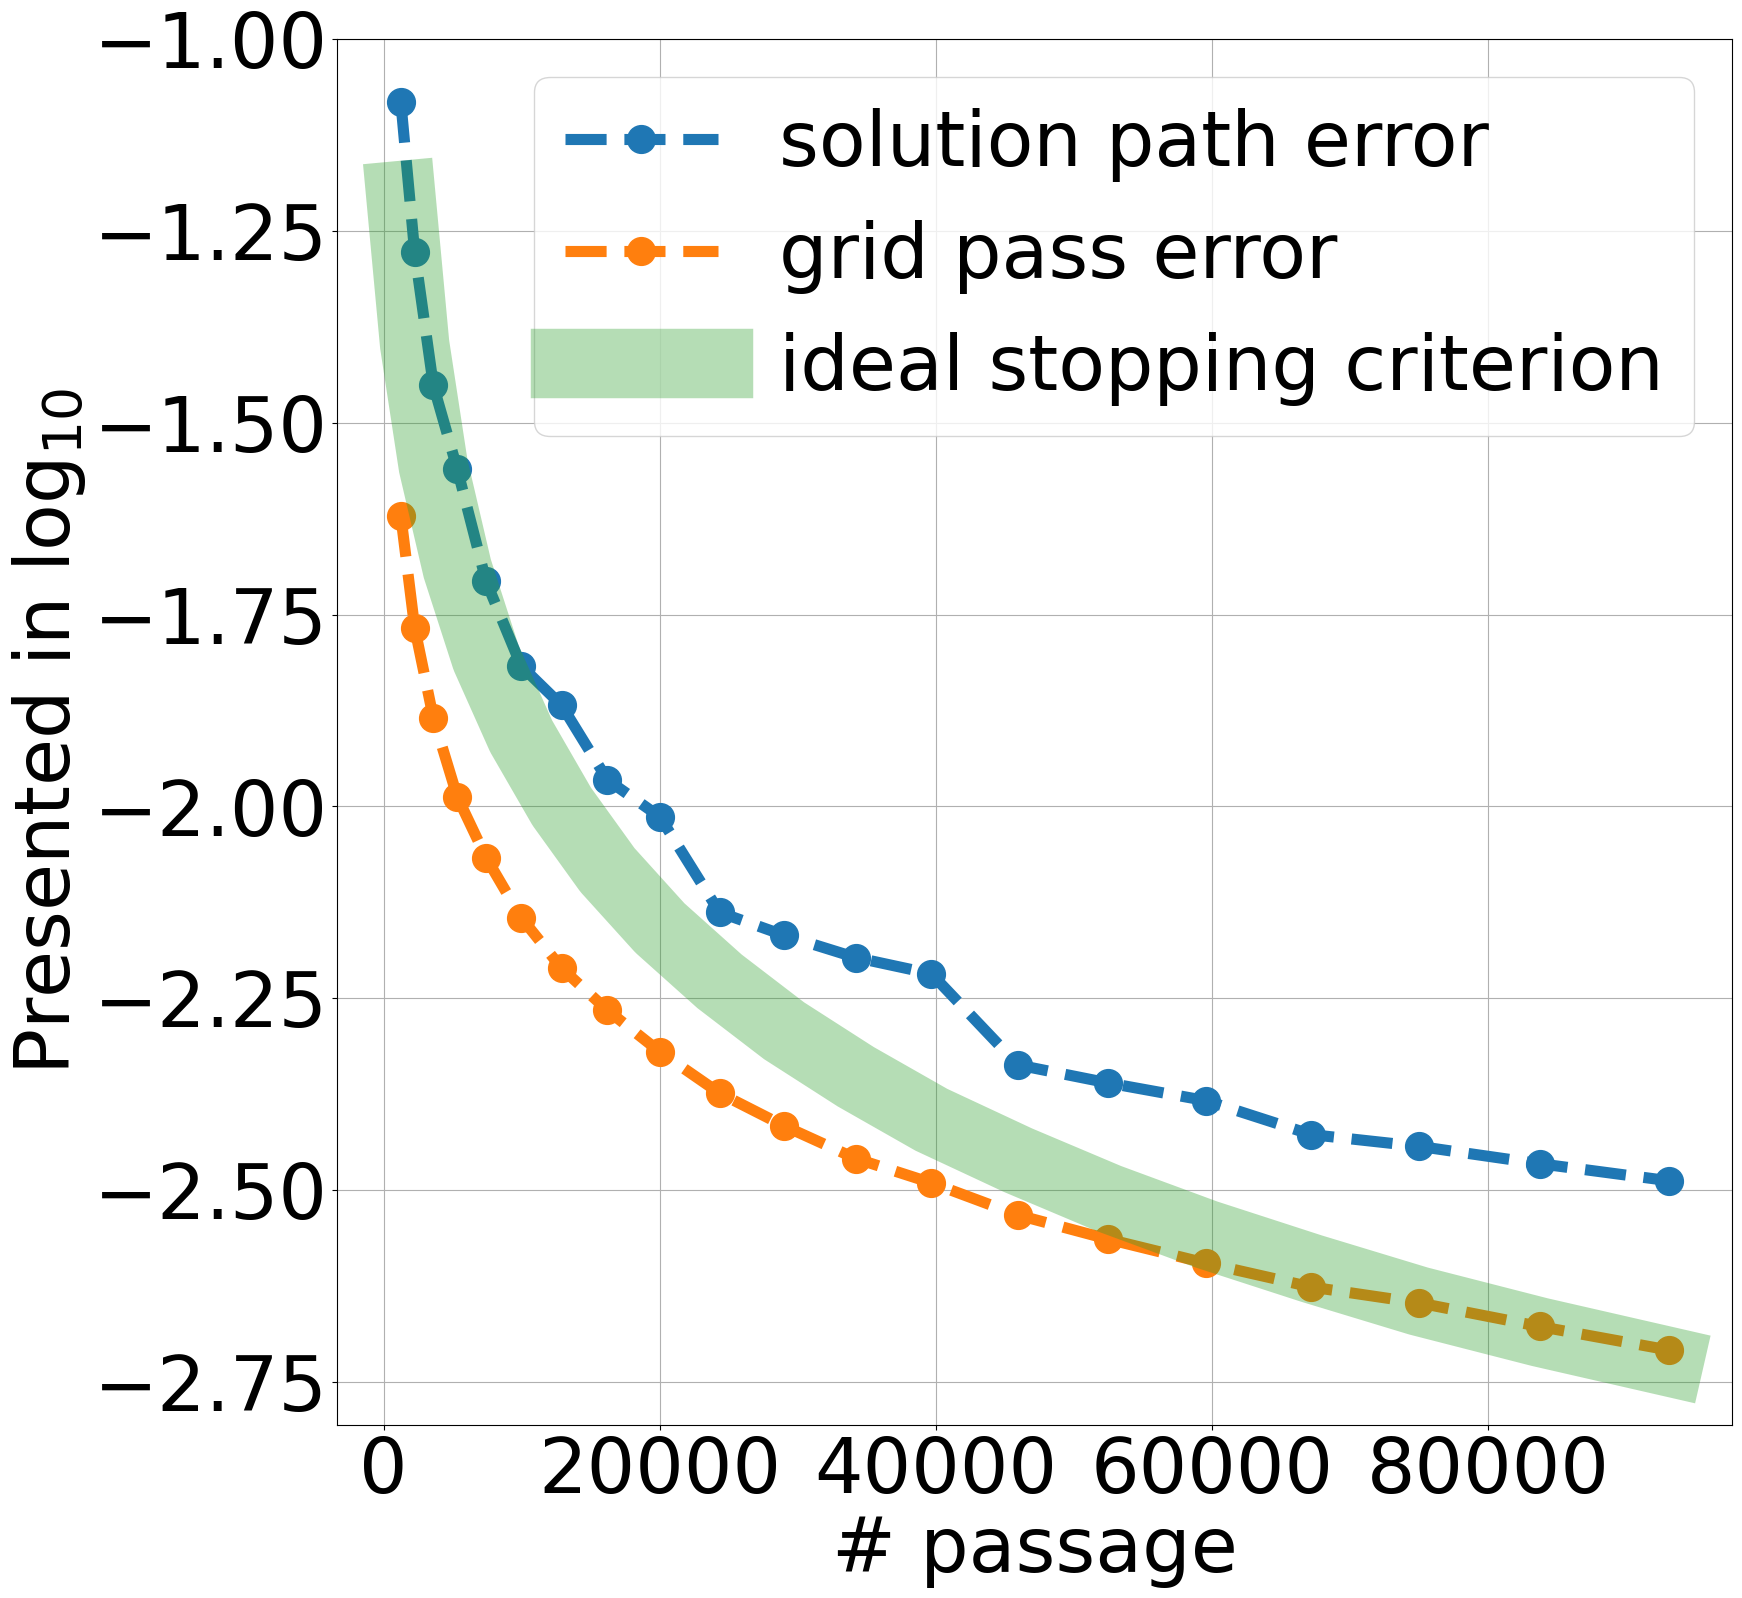

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(total_pass_list, np.log10(sup_error_list), '--o', linewidth=8, markersize=20, label="solution path error")
plt.plot(total_pass_list, np.log10(grid_error_list), '--o', linewidth=8, markersize=20, label="grid pass error")
plt.plot(total_pass_list, np.log10(delta_list), '-', linewidth=50, label="ideal stopping criterion", alpha=0.35)

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# passage', fontsize=font_size)
plt.ylabel('Presented in $\\log_{10}$', fontsize=font_size)
plt.legend()
plt.grid(True)
plt.savefig("NGS_stopping_criterion_exact.png")